# Relative abundance trace graphs

In [1]:
%load_ext rpy2.ipython

In [224]:
%%R
library(phyloseq)
library(ggplot2)
library(plyr); library(dplyr)
library(RColorBrewer)
library(gridExtra)
library(cowplot)

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attaching package: ‘cowplot’


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following object is masked from ‘package:ggplot2’:

    ggsave


  warnings.warn(x, RRuntimeWarning)


# Load data

In [4]:

%%R
log2foldFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/bare-plant.csv'

# use non-rarified relative abundance phylogseq object for consistency with DeSeq
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_relabund')

physeq.Full = readRDS(F)
physeq.Full = filter_taxa(physeq.Full, function(x) sum(x > 0) > 0, TRUE)




# Venn Diagram of OTU occurance

In [292]:
%%R
library(VennDiagram)

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: grid

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: futile.logger

  warnings.warn(x, RRuntimeWarning)


In [293]:
%%R
# merge samples by sample type (rhizosphere vs baresoil) and convert to PA
phy.2pa = NULL 
phy.2pa = physeq.Full %>%
    merge_samples("Planted") %>%
    transform_sample_counts(function(x) ifelse(x == 0,0,1) ) %>%
    otu_table %>%  t() %>% as.data.frame 

  head(phy.2pa)  
    


         BARE Rhizosphere
OTU.4087    1           1
OTU.2009    1           1
OTU.5899    1           1
OTU.4181    1           1
OTU.3052    1           1
OTU.1890    1           1


In [294]:
%%R

barecount = filter(phy.2pa, BARE == 1) %>% nrow
plantcount = filter(phy.2pa, Rhizosphere == 1) %>% nrow
sharedcount = filter(phy.2pa, Rhizosphere == 1 & BARE == 1) %>% nrow
#check rhizosphere OTUs not in bare soil
filter(phy.2pa, Rhizosphere == 0 & BARE == 1) %>% nrow
barecount

[1] 4928


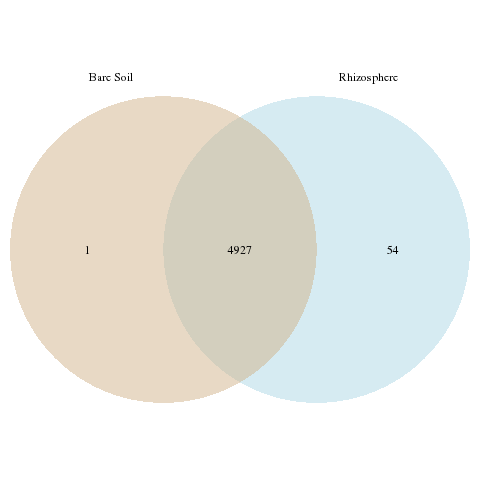

In [396]:
%%R
# Draw venn diagrame
# caution, ordering of labels and colors is backward, always check against actual counts 
# to confirm interpretations

grid.newpage()
pV = draw.pairwise.venn(area1 = plantcount, area2 = barecount, cross.area = sharedcount,
                   category = c("Bare Soil", "Rhizosphere"), lty = rep("blank", 2), 
                 fill = c("lightblue", "tan"), alpha = rep(0.5, 2), cex = 1,
                   cat.dist = .15, cat.cex = 1, scaled = FALSE, rotation.degree = 180) %>% grobTree


# plot rank abundance line in bulk vs rhizosphere soil


In [212]:
%%R
physeq.Plant = subset_samples(physeq.Full, DAP == 84 & Plant == "BARE" | Plant == "HELAN" , TRUE)

mdf = psmelt(physeq.Plant)
physeq.Plant = NULL



In [213]:
%%R
# split dataframe by day and OTU, sumarize mean abundance
mdf.byplanted = ddply(mdf, .(Planted, OTU), summarize, mean_plant_abundance = mean(Abundance))
#Order by day, then rank abundance within day
mdf.byplanted = mdf.byplanted[order(mdf.byplanted$Planted, -mdf.byplanted$mean_plant_abundance),]
head(mdf.byplanted)

     Planted    OTU mean_plant_abundance
3846    BARE  OTU.6          0.016457203
311     BARE OTU.11          0.014640432
543     BARE OTU.12          0.010842170
2303    BARE OTU.28          0.009796865
3799    BARE OTU.58          0.007705291
743     BARE OTU.13          0.007292798


In [214]:
%%R
levels(as.factor(mdf.byplanted$Planted))

[1] "BARE"        "Rhizosphere"


In [215]:
%%R

#Subset to first bulk soil day
mdf.bare = subset(mdf.byplanted, Planted == "BARE")
mdf.bare$Rank = rank(-mdf.bare$mean_plant_abundance, ties.method = "random")
mdf.byplanted.ranked = join(mdf.byplanted, mdf.bare[,c("OTU","Rank")], by = "OTU")

mdf.rhiz = subset(mdf.byplanted, Planted == "Rhizosphere")
mdf.rhiz$Rank = rank(-mdf.rhiz$mean_plant_abundance, ties.method = "random")
#mdf.byplant.ranked = join(mdf.byplant, mdf.bare[,c("OTU","Rank")], by = "OTU")

head(mdf.rhiz)

         Planted      OTU mean_plant_abundance Rank
9377 Rhizosphere    OTU.8           0.03610252    1
5345 Rhizosphere  OTU.112           0.03089330    2
8256 Rhizosphere   OTU.42           0.03026440    3
8218 Rhizosphere   OTU.41           0.01387298    4
7285 Rhizosphere   OTU.28           0.01376119    5
7862 Rhizosphere OTU.3492           0.01262699    6


In [220]:
%%R
mdf.full = rbind(mdf.bare, mdf.rhiz)
head(mdf.full) %>% print
tail(mdf.full)

     Planted    OTU mean_plant_abundance Rank
3846    BARE  OTU.6          0.016457203    1
311     BARE OTU.11          0.014640432    2
543     BARE OTU.12          0.010842170    3
2303    BARE OTU.28          0.009796865    4
3799    BARE OTU.58          0.007705291    5
743     BARE OTU.13          0.007292798    6
         Planted      OTU mean_plant_abundance Rank
9937 Rhizosphere  OTU.990                    0 3681
9945 Rhizosphere OTU.9927                    0 4300
9946 Rhizosphere OTU.9939                    0 4754
9949 Rhizosphere OTU.9949                    0 3777
9951 Rhizosphere OTU.9951                    0 3518
9952 Rhizosphere OTU.9953                    0 4840


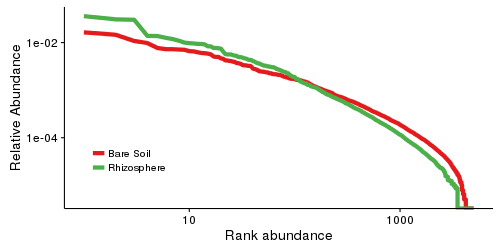

In [410]:
%%R -w 500 -h 250

getPalette = colorRampPalette(brewer.pal(2, "Set1"))

p = ggplot(data = mdf.full, aes(x = Rank, y = mean_plant_abundance, color = Planted))

#p = p + geom_vline(data = d.rhiz, aes(xintercept = Rank), color = "#377eb8", alpha = 0.25, size = 1)
#p = p + geom_vline(data = d.xyl, aes(xintercept = Rank), color = "#4daf4a", alpha = 0.25, size = 1)

p = p + geom_line(alpha = 1, size = 2) 

#p = p + geom_rug(data = d.cell, color = "black", sides = "b", size = 1.25)
#p = p + geom_rug(data = d.rhiz, color = "black", sides = "t", size = .5)

#p = p + geom_line(data = mdf.rhiz, aes(x = Rank, y = mean_plant_abundance), color = "blue", alpha = 1, size = 2)

p = p + scale_color_manual(values=getPalette(2), labels = c("Bare Soil", "Rhizosphere")) 


p = p + scale_y_log10()

p = p + scale_x_log10()

#p = p + theme_bw(base_size = 12)

p = p + labs(x = "Rank abundance", y = "Relative Abundance")

p = p + theme(legend.position = c(.15, .25), legend.text = element_text(size = 10), legend.title = element_blank())
p7 = p 
p7

#  Bare soils by time graph

In [167]:
%%R
physeq.Bare = subset_samples(physeq.Full, Type == "BARE", TRUE)
mdf = psmelt(physeq.Bare)
physeq.Bare = NULL
head(mdf)

          OTU            Sample  Abundance          X.sample Library
34714  OTU.12 sample8-3.07_Npos 0.02789850 sample8-3.07_Npos       2
246137  OTU.6 sample8-3.07_Npos 0.02523482 sample8-3.07_Npos       2
246087  OTU.6 sample6-2.05_Npos 0.02493613 sample6-2.05_Npos       2
246118  OTU.6 sample2-2.05_Npos 0.02408155 sample2-2.05_Npos       1
246142  OTU.6 sample8-2.05_Npos 0.02323952 sample8-2.05_Npos       2
246109  OTU.6 sample4-1.06_Npos 0.02293637 sample4-1.06_Npos       2
       Primer_Plate Primer_Well_ID primerFR_ID_byPlate primerFR_ID_total
34714             1             F7                  54                54
246137            1             F7                  54                54
246087            1             F1                   6                 6
246118            1            B10                  74                74
246142            1             D7                  52                52
246109            1             E1                   5                 5
      

In [168]:
%%R
# split dataframe by day and OTU, sumarize mean abundance
mdf.byday = ddply(mdf, .(DAP, OTU), summarize, mean_day_abundance = mean(Abundance))
head(mdf.byday)

  DAP       OTU mean_day_abundance
1  36    OTU.10       1.881108e-03
2  36   OTU.100       2.943948e-03
3  36  OTU.1000       5.313401e-05
4  36 OTU.10004       1.019494e-04
5  36 OTU.10009       2.386498e-06
6  36  OTU.1001       0.000000e+00


In [169]:
%%R
#Order by day, then rank abundance within day
mdf.byday = mdf.byday[order( mdf.byday$DAP, -mdf.byday$mean_day_abundance),]
#Subset to first bulk soil day
mdf.36 = subset(mdf.byday, DAP == 36)

mdf.36$Rank = rank(-mdf.36$mean_day_abundance, ties.method = "random")
mdf.byday.ranked = join(mdf.byday, mdf.36[,c("OTU","Rank")], by = "OTU")

head(mdf.byday.ranked)

  DAP    OTU mean_day_abundance Rank
1  36  OTU.6        0.017623251    1
2  36 OTU.28        0.011306851    2
3  36 OTU.11        0.009433516    3
4  36 OTU.12        0.008705002    4
5  36 OTU.47        0.008015766    5
6  36 OTU.13        0.007286370    6


In [170]:
%%R
FDR = 0.05

# read rhizosphere log2fold change file and 
l2f = read.csv(log2foldFile, header = TRUE) 

df.l2fc.rspndr = l2f %>%
    group_by(OTU) %>%
     summarize(minP = min(p.adj)) %>% 
     filter(minP <= FDR)

In [171]:
%%R

d.rhiz = left_join(df.l2fc.rspndr, mdf.byday.ranked)


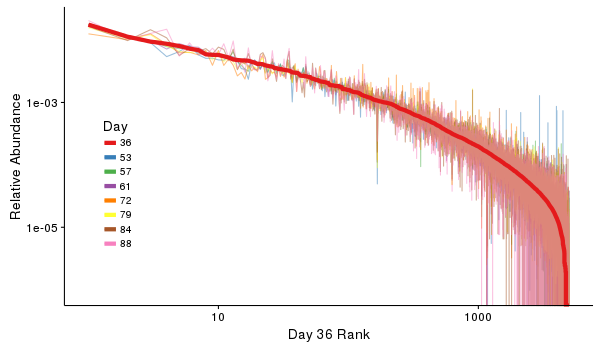

In [291]:
%%R -w 600 -h 350
getPalette = colorRampPalette(brewer.pal(8, "Set1"))
require(cowplot)
p = ggplot(mdf.byday.ranked, aes(x = Rank, y = mean_day_abundance, color = factor(DAP))) 

#p = p + geom_vline(data = d.rhiz, aes(xintercept = Rank), color = "#377eb8", alpha = 0.25, size = 1)
#p = p + geom_vline(data = d.xyl, aes(xintercept = Rank), color = "#4daf4a", alpha = 0.25, size = 1)

p = p + geom_line(alpha = 0.5, size = 0.5) 

#p = p + geom_rug(data = d.cell, color = "black", sides = "b", size = 1.25)
#p = p + geom_rug(data = d.rhiz, color = "black", sides = "t", size = 1.25)

p = p + geom_line(data = subset(mdf.byday.ranked, DAP == 36), size = 2)

p = p + scale_color_manual(values=getPalette(8))

p = p + scale_y_log10()

p = p + scale_x_log10()

#p = p + theme_bw(base_size = 12)

p = p + labs(x = "Day 36 Rank", y = "Relative Abundance", color = "Day")
p = p + theme(legend.position = c(.10, .40), legend.text = element_text(size = 10))

p1 = p
p1

In [ ]:
# Now rhizosphere plots

# Plot day 84 with 84 rank abundance as baseline

In [237]:
%%R
physeq.Plant = subset_samples(physeq.Full, DAP == 84 , TRUE)

mdf = psmelt(physeq.Plant)
physeq.Plant = NULL



In [239]:
%%R
# split dataframe by day and OTU, sumarize mean abundance
mdf.byplant = ddply(mdf, .(Plant, OTU), summarize, mean_plant_abundance = mean(Abundance))
head(mdf.byplant)%%R
physeq.Plant = subset_samples(physeq.Full, DAP == 84 , TRUE)

mdf = psmelt(physeq.Plant)
physeq.Plant = NULL






Error in withVisible({ : object 'R' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in withVisible({ : object 'R' not found

  warnings.warn(x, RRuntimeWarning)


In [240]:
%%R
#Order by day, then rank abundance within day
mdf.byplant = mdf.byplant[order(mdf.byplant$Plant, -mdf.byplant$mean_plant_abundance),]

#Subset to first bulk soil day
mdf.bare = subset(mdf.byplant, Plant == "BARE")
mdf.bare$Rank = rank(-mdf.bare$mean_plant_abundance, ties.method = "random")
mdf.byplant.ranked = join(mdf.byplant, mdf.bare[,c("OTU","Rank")], by = "OTU")

head(mdf.byplant.ranked)

  Plant    OTU mean_plant_abundance Rank
1  BARE  OTU.6          0.016457203    1
2  BARE OTU.11          0.014640432    2
3  BARE OTU.12          0.010842170    3
4  BARE OTU.28          0.009796865    4
5  BARE OTU.58          0.007705291    5
6  BARE OTU.13          0.007292798    6


In [241]:
%%R
FDR = 0.05

# read rhizosphere log2fold change file and 
l2f = read.csv(log2foldFile, header = TRUE) 

df.l2fc.rspndr = l2f %>%
    filter(Day == 84 & log2FoldChange > 0) %>%
    group_by(OTU) %>%
     summarize(minP = min(p.adj)) %>% 
     filter(minP <= FDR)

In [242]:
%%R

d.rhiz = left_join(df.l2fc.rspndr, mdf.byplant.ranked)


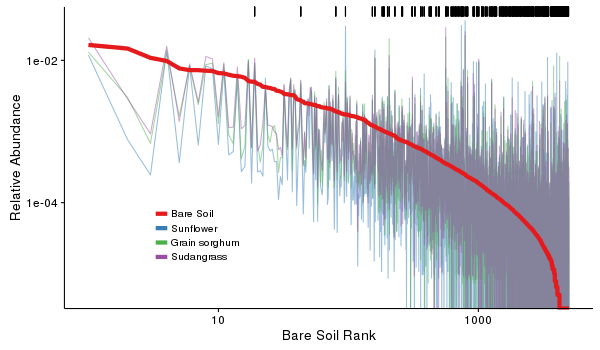

In [394]:
%%R -w 600 -h 350

getPalette = colorRampPalette(brewer.pal(9, "Set1"))

p = ggplot(mdf.byplant.ranked, aes(x = Rank, y = mean_plant_abundance, color = Plant)) 

#p = p + geom_vline(data = d.rhiz, aes(xintercept = Rank), color = "#377eb8", alpha = 0.25, size = 1)
#p = p + geom_vline(data = d.xyl, aes(xintercept = Rank), color = "#4daf4a", alpha = 0.25, size = 1)

p = p + geom_line(alpha = 0.5, size = 0.5) 

#p = p + geom_rug(data = d.cell, color = "black", sides = "b", size = 1.25)
p = p + geom_rug(data = d.rhiz, color = "black", sides = "t", size = .5)

p = p + geom_line(data = subset(mdf.byplant.ranked, Plant == "BARE"), size = 2)

p = p + scale_color_manual(values=getPalette(9), labels = c("Bare Soil", "Sunflower", "Grain sorghum", "Sudangrass")) 


p = p + scale_y_log10()

p = p + scale_x_log10()

#p = p + theme_bw(base_size = 12)

p = p + labs(x = "Bare Soil Rank", y = "Relative Abundance")

p = p + theme(legend.position = c(.25, .25), legend.text = element_text(size = 10), legend.title = element_blank())
p6 = p 
p6

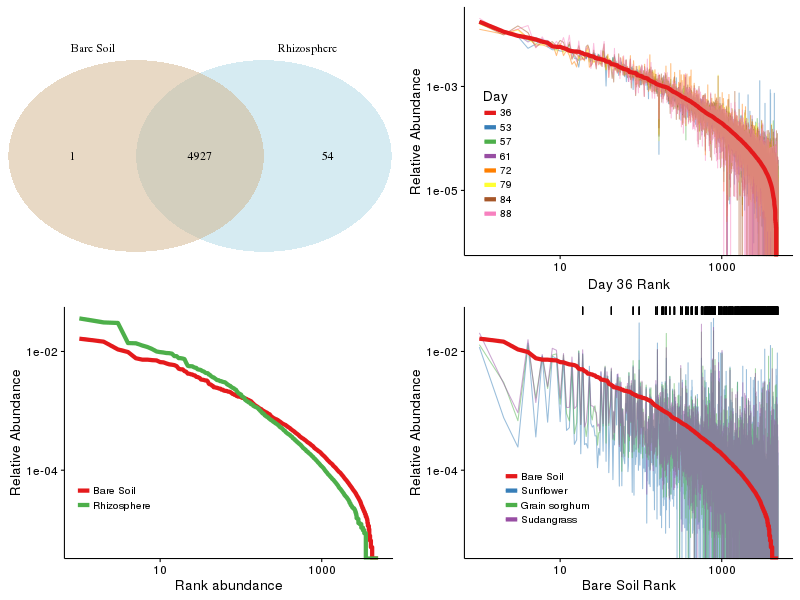

In [411]:
%%R -w 800 -h 600
grid.arrange(pV, p1, p7, p6, ncol = 2)

In [412]:
%%R -w 700 -h 600
g.b = textGrob("")
tiff("/home/bryan/RhizCG/figures/relabund_trace.tiff", width = 8, height = 6, units = "in", res = 150)
grid.arrange(pV, p1, p7, p6, widths = 2:3, ncol = 2)
dev.off()

png 
  2 


In [406]:
%%R
postscript(file = "/home/bryan/RhizCG/figures/relabund_trace.ps", width = 8, height = 6)
grid.arrange(pV, p1, g.b, p6, ncol = 2, widths = 2:3)
dev.off()


Error in grid.Call.graphics(L_text, as.graphicsAnnot(x$label), x$x, x$y,  : 
  family 'serif' not included in postscript() device


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in grid.Call.graphics(L_text, as.graphicsAnnot(x$label), x$x, x$y,  : 
  family 'serif' not included in postscript() device

  warnings.warn(x, RRuntimeWarning)


# Arrange with cowplot

In [345]:
%%R
grid.arrange(pV), p1, p6, ncol = 2)

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in gList(list(name = "arrange.1-1-1-1", gp = NULL, vp = NULL, children = list( : 
  only 'grobs' allowed in "gList"

  warnings.warn(x, RRuntimeWarning)



Error in gList(list(name = "arrange.1-1-1-1", gp = NULL, vp = NULL, children = list( : 
  only 'grobs' allowed in "gList"


In [327]:
%%R
plot_grid(grobTree(pV), p1, NULL, p6, labels = c("A", "B", "", "C"), ncol = 2, align = "v")


Error in ggplot_to_gtable(x) : 
  Argument needs to be of class "ggplot" or "gtable"


In [274]:
%%R
plot2by1 <- plot_grid(p1, p6, labels = c("A", "B"), ncol = 1, align = "v")
save_plot("/home/bryan/RhizCG/figures/relabund_trace.pdf", plot2by1,
          ncol = 1, # we're saving a grid plot of 2 columns
          nrow = 2, # and 2 rows
          # each individual subplot should have an aspect ratio of 1.3
          base_aspect_ratio = 1.3
          )

In [269]:
%%R
?save_plot

R Help on ‘save_plot’save_plot               package:cowplot                R Documentation

_A_l_t_e_r_n_a_t_i_v_e _t_o _g_g_s_a_v_e, _w_i_t_h _b_e_t_t_e_r _s_u_p_p_o_r_t _f_o_r _m_u_l_t_i-_f_i_g_u_r_e _p_l_o_t_s.

_D_e_s_c_r_i_p_t_i_o_n:

     This function replaces the standard ‘ggsave’ function for saving a
     plot into a file. It has several advantages over ‘ggsave’. First,
     it uses default sizes that work well with the cowplot theme, so
     that frequently a plot size does not have to be explicitly
     specified. Second, it acknowledges that one often first develops
     individual plots and then combines them into multi-plot figures,
     and it makes it easy-in combination with ‘plot_grid’-to carry out
     this workflow. Finally, it makes it easy to adjust the aspect
     ratio of the figure, which is frequently necessary to accommodate
     the figure legend.

_U_s_a_g_e:

     save_plot(filename, 

# Sandbox

In [25]:
%%R
physeq.Plant = subset_samples(physeq.Full, DAP == 84 | DAP == 36 & Plant == "BARE" , TRUE)

mdf = psmelt(physeq.Plant)
physeq.Plant = NULL



In [26]:
%%R
# split dataframe by day and OTU, sumarize mean abundance
mdf.byday.byplant = ddply(mdf, .(DAP, Plant, OTU), summarize, mean_day_abundance = mean(Abundance))
head(mdf.byday.byplant)

  DAP Plant       OTU mean_day_abundance
1  36  BARE    OTU.10       1.881108e-03
2  36  BARE   OTU.100       2.943948e-03
3  36  BARE  OTU.1000       5.313401e-05
4  36  BARE OTU.10004       1.019494e-04
5  36  BARE OTU.10009       2.386498e-06
6  36  BARE  OTU.1001       0.000000e+00


In [28]:
%%R
#Order by day, then rank abundance within day
mdf.byday.byplant = mdf.byday.byplant[order( mdf.byday.byplant$DAP, -mdf.byday.byplant$mean_day_abundance),]
#Subset to first bulk soil day
mdf.36 = subset(mdf.byday.byplant, DAP == 36 & Plant == "BARE")

mdf.36$Rank = rank(-mdf.36$mean_day_abundance, ties.method = "random")
mdf.byday.byplant.ranked = join(mdf.byday.byplant, mdf.36[,c("OTU","Rank")], by = "OTU")

head(mdf.byday.byplant.ranked)

  DAP Plant    OTU mean_day_abundance Rank
1  36  BARE  OTU.6        0.017623251    1
2  36  BARE OTU.28        0.011306851    2
3  36  BARE OTU.11        0.009433516    3
4  36  BARE OTU.12        0.008705002    4
5  36  BARE OTU.47        0.008015766    5
6  36  BARE OTU.13        0.007286370    6


In [65]:
%%R
FDR = 0.05

# read rhizosphere log2fold change file and 
l2f = read.csv(log2foldFile, header = TRUE) 

df.l2fc.rspndr = l2f %>%
    filter(Day == 84 & log2FoldChange > 0) %>%
    group_by(OTU) %>%
     summarize(minP = min(p.adj)) %>% 
     filter(minP <= FDR)

In [71]:
%%R
head(df.l2fc.rspndr)

# A tibble: 6 × 2
        OTU         minP
     <fctr>        <dbl>
1    OTU.10 9.458241e-20
2   OTU.101 1.822706e-03
3  OTU.1010 4.076361e-02
4  OTU.1016 2.854686e-03
5 OTU.10219 1.004318e-02
6 OTU.10249 1.877634e-02


In [72]:
%%R

d.rhiz = left_join(df.l2fc.rspndr, mdf.byday.byplant.ranked)


In [73]:
%%R
mdf.byday.byplant.ranked$Plant_Day = paste(mdf.byday.byplant.ranked$Plant, mdf.byday.byplant.ranked$DAP, sep = "-")

In [233]:
%%R -w 1000 -h 350

getPalette = colorRampPalette(brewer.pal(5, "Set1"))

p = ggplot(mdf.byday.byplant.ranked, aes(x = Rank, y = mean_day_abundance, color = Plant_Day)) 

#p = p + geom_vline(data = d.rhiz, aes(xintercept = Rank), color = "#377eb8", alpha = 0.25, size = 1)
#p = p + geom_vline(data = d.xyl, aes(xintercept = Rank), color = "#4daf4a", alpha = 0.25, size = 1)

p = p + geom_line(alpha = 0.5, size = 0.8) 

#p = p + geom_rug(data = d.cell, color = "black", sides = "b", size = 1.25)
p = p + geom_rug(data = d.rhiz, color = "black", sides = "t", size = .5)

#p = p + geom_line(data = subset(mdf.byday.byplant.ranked, DAP == 36), size = 2)
p = p + geom_line(data = subset(mdf.byday.byplant.ranked, DAP == 84 & Plant == "BARE"), alpha = .5, size = 1.2)

p = p + scale_color_manual(values=getPalette(5))

p = p + scale_y_log10()

p = p + scale_x_log10()

#p = p + theme_bw()

p = p + labs(x = "Day 36 Bare Soil Rank", y = "Relative Abundance", color = "Day")

p3 = p 

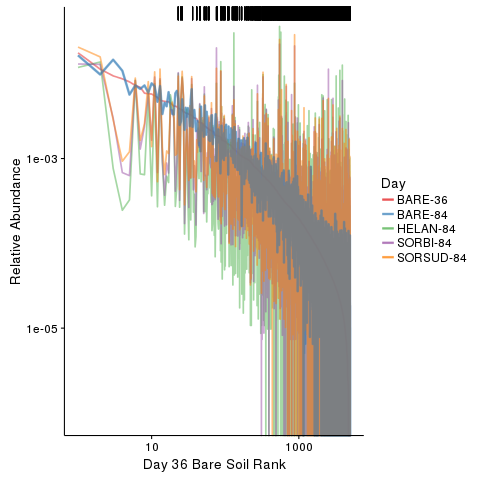

In [234]:
%%R
p3

In [ ]:
## format for 

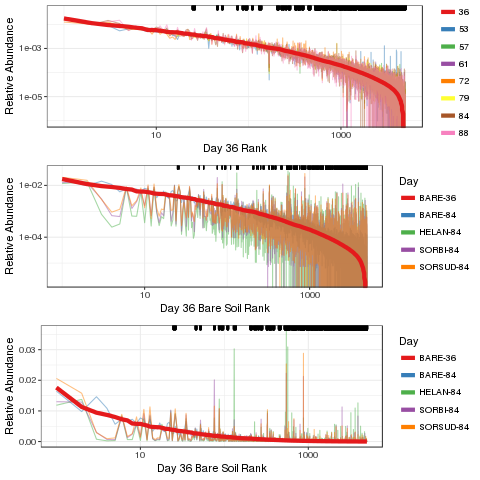

In [58]:
%%R
grid.arrange(p1,p3,p2, ncol = 1)

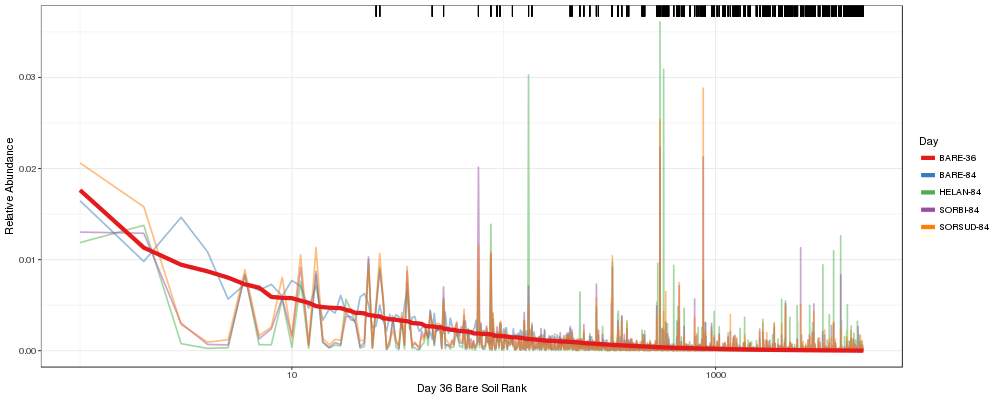

In [75]:
%%R -w 1000 -h 400
p2


# by day Rhizosphere samples and bulk 36

In [113]:
%%R
physeq.Plant = subset_samples(physeq.Full, Planted == "Rhizosphere" | DAP == 36 & Plant == "BARE" , TRUE)

mdf = psmelt(physeq.Plant)
physeq.Plant = NULL



In [114]:
%%R
head(mdf)

          OTU            Sample Abundance          X.sample Library
821181 OTU.84 sample3-3.30_Npos 0.2773169 sample3-3.30_Npos       2
271824 OTU.20 sample2-2.10_Nneg 0.2432191 sample2-2.10_Nneg       2
271887 OTU.20 sample2-1.08_Nneg 0.1414608 sample2-1.08_Nneg       1
747536  OTU.7 sample5-3.17_Nneg 0.1369265 sample5-3.17_Nneg       1
452845  OTU.3 sample5-3.13_Nneg 0.1360758 sample5-3.13_Nneg       1
578452  OTU.4 sample3-4.18_Nneg 0.1355695 sample3-4.18_Nneg       2
       Primer_Plate Primer_Well_ID primerFR_ID_byPlate primerFR_ID_total
821181            1            E12                  93                93
271824            1             A2                   9                 9
271887            1             A7                  49                49
747536            1             E2                  13                13
452845            2             E1                   5               101
578452            1             A3                  17                17
       barcod

In [115]:
%%R
# split dataframe by day and OTU, sumarize mean abundance
mdf.byday = ddply(mdf, .(DAP, Planted, OTU), summarize, mean_day_abundance = mean(Abundance))
head(mdf.byday)

  DAP Planted       OTU mean_day_abundance
1  36    BARE    OTU.10       1.881108e-03
2  36    BARE   OTU.100       2.943948e-03
3  36    BARE  OTU.1000       5.313401e-05
4  36    BARE OTU.10004       1.019494e-04
5  36    BARE OTU.10009       2.386498e-06
6  36    BARE  OTU.1001       0.000000e+00


In [116]:
%%R
#Order by day, then rank abundance within day
mdf.byday = mdf.byday[order( mdf.byday$DAP, -mdf.byday$mean_day_abundance),]
#Subset to first bulk soil day
mdf.36 = subset(mdf.byday, DAP == 36 & Planted == "BARE")

mdf.36$Rank = rank(-mdf.36$mean_day_abundance, ties.method = "random")
mdf.byday.ranked = join(mdf.byday, mdf.36[,c("OTU","Rank")], by = "OTU")

head(mdf.byday.ranked)

  DAP     Planted    OTU mean_day_abundance Rank
1  36 Rhizosphere  OTU.8        0.020629371  547
2  36        BARE  OTU.6        0.017623251    1
3  36 Rhizosphere  OTU.4        0.012971579  274
4  36        BARE OTU.28        0.011306851    2
5  36 Rhizosphere OTU.11        0.010989811    3
6  36        BARE OTU.11        0.009433516    3


In [117]:
%%R
FDR = 0.05

# read rhizosphere log2fold change file and 
l2f = read.csv(log2foldFile, header = TRUE) 

df.l2fc.rspndr = l2f %>%
    filter(Day == 84 & log2FoldChange > 0) %>%
    group_by(OTU) %>%
     summarize(minP = min(p.adj)) %>% 
     filter(minP <= FDR)

In [118]:
%%R
head(df.l2fc.rspndr)

# A tibble: 6 × 2
        OTU         minP
     <fctr>        <dbl>
1    OTU.10 9.458241e-20
2   OTU.101 1.822706e-03
3  OTU.1010 4.076361e-02
4  OTU.1016 2.854686e-03
5 OTU.10219 1.004318e-02
6 OTU.10249 1.877634e-02


In [119]:
%%R

d.rhiz = left_join(df.l2fc.rspndr, mdf.byday.ranked)


In [120]:
%%R
mdf.byday.ranked$Planted_Day = paste(mdf.byday.ranked$Planted, mdf.byday.ranked$DAP, sep = "-")

In [121]:
%%R -w 1000 -h 350

getPalette = colorRampPalette(brewer.pal(9, "Set1"))

p = ggplot(mdf.byday.ranked, aes(x = Rank, y = mean_day_abundance, color = Planted_Day)) 

#p = p + geom_vline(data = d.rhiz, aes(xintercept = Rank), color = "#377eb8", alpha = 0.25, size = 1)
#p = p + geom_vline(data = d.xyl, aes(xintercept = Rank), color = "#4daf4a", alpha = 0.25, size = 1)

p = p + geom_line(alpha = 0.5, size = 0.8) 

#p = p + geom_rug(data = d.cell, color = "black", sides = "b", size = 1.25)
p = p + geom_rug(data = d.rhiz, color = "black", sides = "t", size = .5)

p = p + geom_line(data = subset(mdf.byday.ranked, Planted == "BARE"), size = 2)

p = p + scale_color_manual(values=getPalette(9))

p = p + scale_y_log10()

p = p + scale_x_log10()

p = p + theme_bw()

p = p + labs(x = "Day 36 Bare Soil Rank", y = "Relative Abundance", color = "Day")

p4 = p 

# Use B73 for rank abundance and plot maize variation on the same day

In [96]:
%%R
physeq.Plant = subset_samples(physeq.Full, DAP == 84 , TRUE)

mdf = psmelt(physeq.Plant)
physeq.Plant = NULL



In [97]:
%%R
# split dataframe by day and OTU, sumarize mean abundance
mdf.byplant = ddply(mdf, .(Plant, OTU), summarize, mean_plant_abundance = mean(Abundance))
head(mdf.byplant)

  Plant       OTU mean_plant_abundance
1   B73    OTU.10         2.055621e-02
2   B73   OTU.100         1.196080e-03
3   B73  OTU.1000         3.497794e-05
4   B73 OTU.10004         6.959503e-05
5   B73 OTU.10009         4.747308e-05
6   B73  OTU.1001         3.801253e-05


In [103]:
%%R
#Order by day, then rank abundance within day
mdf.byplant = mdf.byplant[order(mdf.byplant$Plant, -mdf.byplant$mean_plant_abundance),]

#Subset to first bulk soil day
mdf.B73 = subset(mdf.byplant, Plant == "B73")
mdf.B73$Rank = rank(-mdf.B73$mean_plant_abundance, ties.method = "random")
mdf.byplant.ranked = join(mdf.byplant, mdf.B73[,c("OTU","Rank")], by = "OTU")

head(mdf.byplant.ranked)

  Plant    OTU mean_plant_abundance Rank
1   B73  OTU.3           0.04035030    1
2   B73  OTU.7           0.04032706    2
3   B73  OTU.9           0.03414476    3
4   B73  OTU.8           0.02222233    4
5   B73 OTU.10           0.02055621    5
6   B73  OTU.4           0.02021365    6


In [104]:
%%R
FDR = 0.05

# read rhizosphere log2fold change file and 
l2f = read.csv(log2foldFile, header = TRUE) 

df.l2fc.rspndr = l2f %>%
    filter(Day == 79 & log2FoldChange > 0) %>%
    group_by(OTU) %>%
     summarize(minP = min(p.adj)) %>% 
     filter(minP <= FDR)

In [105]:
%%R

d.rhiz = left_join(df.l2fc.rspndr, mdf.byplant.ranked)


In [88]:
%%R
#mdf.byplant.ranked$Planted_Day = paste(mdf.byday.ranked$Planted, mdf.byday.ranked$DAP, sep = "-")

In [122]:
%%R -w 1000 -h 350

getPalette = colorRampPalette(brewer.pal(9, "Set1"))

p = ggplot(mdf.byplant.ranked, aes(x = Rank, y = mean_plant_abundance, color = Plant)) 

#p = p + geom_vline(data = d.rhiz, aes(xintercept = Rank), color = "#377eb8", alpha = 0.25, size = 1)
#p = p + geom_vline(data = d.xyl, aes(xintercept = Rank), color = "#4daf4a", alpha = 0.25, size = 1)

p = p + geom_line(data = subset(mdf.byplant.ranked, Plant != "BARE"), alpha = 0.5, size = 0.8) 

#p = p + geom_rug(data = d.cell, color = "black", sides = "b", size = 1.25)
p = p + geom_rug(data = d.rhiz, color = "black", sides = "t", size = .5)

p = p + geom_line(data = subset(mdf.byplant.ranked, Plant == "B73"), size = 2)

p = p + scale_color_manual(values=getPalette(9))

p = p + scale_y_log10()

p = p + scale_x_log10()

p = p + theme_bw()

p = p + labs(x = "B73 Rank", y = "Relative Abundance", color = "Day")

p5 = p 

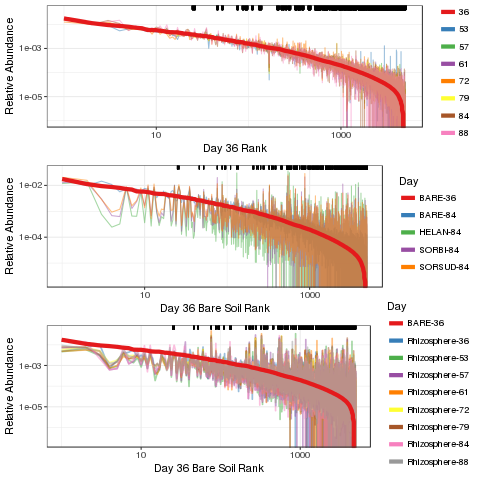

In [125]:
%%R
grid.arrange(p1, p3, p4, ncol = 1)

In [88]:
%%R
#mdf.byplant.ranked$Planted_Day = paste(mdf.byday.ranked$Planted, mdf.byday.ranked$DAP, sep = "-")